# Projeto Aprendizagem Automática Avançada

# Trabalho laboratorial Nº 1

### Alunos: 
* A45102 Miguel Távora
* A45140 Duarte Domingues


<hr style="border:2px solid black"> </hr>

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras

# Bibliotecas Auxiliares
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.datasets as DT
import cv2
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.metrics as skm


### Carregar os dados

In [2]:
# the data is already shuffled
cifar10=keras.datasets.cifar10
(Xtrain,ytrain),(Xtest,ytest)=cifar10.load_data()

In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
classesBin = ('Not Ship','Is Ship')

### Classes binárias

In [5]:
#binary labels, only for the ships
ytrain_b = (ytrain == classes.index('ship')) * 1
ytest_b = (ytest == classes.index('ship')) * 1
print("Classes diferentes(treino): "+str(np.unique(ytrain_b)), "Classes 0: "+str(np.sum(ytrain_b == 0)), 
      "Classes 0: "+str(np.sum(ytrain_b == 1)))
print("Classes diferentes(teste): "+str(np.unique(ytest_b)), np.sum(ytest_b == 0), np.sum(ytest_b == 1))

Classes diferentes(treino): [0 1] Classes 0: 45000 Classes 0: 5000
Classes diferentes(teste): [0 1] 9000 1000


In [6]:
print("Shape train: "+str(Xtrain.shape))
print("Shape test: "+str(Xtest.shape))

Shape train: (50000, 32, 32, 3)
Shape test: (10000, 32, 32, 3)


In [7]:
# it converts the (50000, 1) shape into (50000, )
ytrain = ytrain.flatten()
ytest = ytest.flatten()

<hr style="border:2px solid black"> </hr>

### Função de visualização da Matriz confusão

In [8]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig=plt.figure(figsize=(6.5,6.5))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig

### Exibir uma imagem

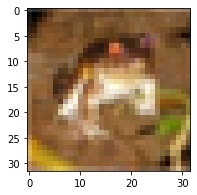

In [9]:
plt.figure(figsize=(3,3))
plt.imshow(Xtrain[0],cmap='binary')

### Mostrar imagens por classe

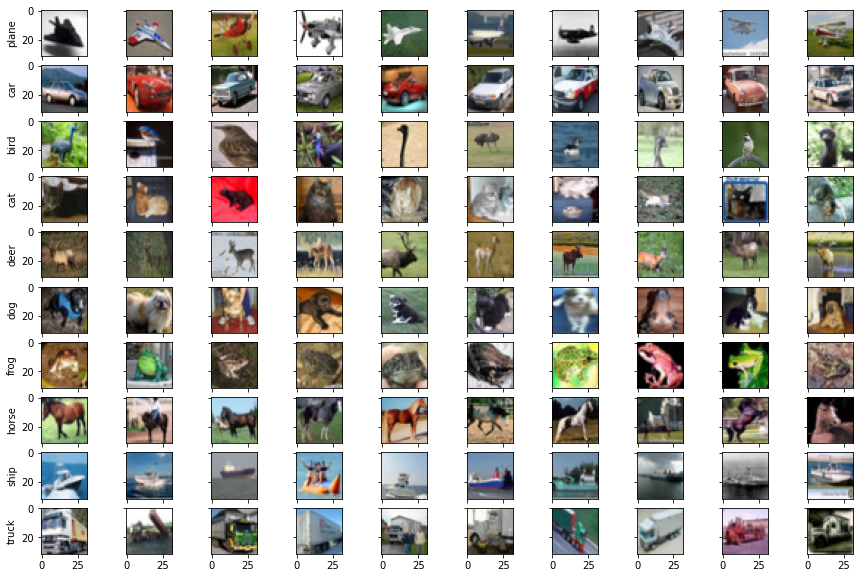

In [10]:
#Subplot para 10 imagens para cada classe
fig, subs = plt.subplots(nrows=10, ncols=10, figsize=(15, 10),squeeze=True)

idxList=[]
for i in range(10):
    idxTemp=np.argwhere(ytrain==i).squeeze()
    idxList.append(idxTemp)

    
for i in range(10):
    idx=idxList[i]    
    for n in range(10):
        Img= Xtrain[idx[n]]
        subs[i, n].set(ylabel=str(classes[i]))
        subs[i,n].label_outer()
        iplt = subs[i, n]
        iplt.imshow(Img,cmap='binary')

## Converter imagens para gray para prevenir fits muito longos

tipo dados(treino): float64
tipo dados(teste): float64


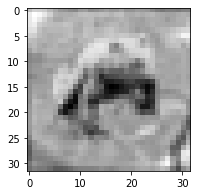

In [11]:
# list compreheension to convert all the images to gray this way its easier to classify
Xtrain_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in Xtrain]) * 1. # the * 1. is to convert to float
Xtest_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in Xtest]) * 1. # the * 1. is to convert to float
print("tipo dados(treino): "+str(Xtrain_gray[0].dtype))
print("tipo dados(teste): "+str(Xtest_gray[0].dtype))
plt.figure(figsize=(3,3))
plt.imshow(Xtrain_gray[0],cmap='binary')

## Reshape dos dados

In [12]:
Xtrain=Xtrain.reshape((Xtrain.shape[0],Xtrain.shape[1]**2*Xtrain.shape[3]))*1. #reshape e converter para float
Xtest=Xtest.reshape((Xtest.shape[0],Xtest.shape[1]**2*Xtest.shape[3]))*1. #reshape e converter para float
print(Xtrain.shape)
print(Xtest.shape)

(50000, 3072)
(10000, 3072)


In [13]:
Xtrain_gray = Xtrain_gray.reshape((Xtrain_gray.shape[0],Xtrain_gray.shape[1]**2)) #reshape
Xtest_gray = Xtest_gray.reshape((Xtest_gray.shape[0],Xtest_gray.shape[1]**2)) #reshape
print(Xtrain_gray.shape)
print(Xtest_gray.shape)

(50000, 1024)
(10000, 1024)


<hr style="border:2px solid black"> </hr>

# Classificação multiclasse

A primeira tarefa a ser realizada foi a tarefa de classificação multiclasse. Para esta tarefa foram
testados diferentes classificadores de forma a averiguar qual deles obtém melhores resultados. 

## Classificador Estocástico Descida de Gradiente (SGDClassifier)

O primeiro classificador a ser averiguado é um classificador de descida de gradiente (SGDClassifier). Este classificador aplica um modelo de regularização linear com descida de gradiente estocástica, este 
classificador foi escolhido para ser testado porque funciona bem com dados de larga escala.
* Inicialmente foi testado o modelo sem qualquer tipo de ajuste dos hiper-parâmetros do classificador, de forma a ter uma ideia inicial do desempenho.

In [16]:
#Iniciar o modelo
sgd = SGDClassifier(max_iter=5000, random_state=42, n_jobs=5).fit(Xtrain,ytrain)
#prever dados de treino
y2train = sgd.predict(Xtrain)
#prever dados de teste
y2e = sgd.predict(Xtest)

In [17]:
confTrain = confusion_matrix(ytrain,y2train)
print(confTrain)
print("Número erros(treino): "+str(np.sum(ytrain != y2train)))

[[ 597  278 3109  105    2  106    9  269  468   57]
 [  43 2893 1176  138   11  114   37  191  244  153]
 [  26  163 4368  110    2   75   29  125   82   20]
 [  34  314 2880 1048    7  339   51  168   99   60]
 [  43  191 3834  183   76  211   62  292   60   48]
 [  18  249 3238  411    5  751   27  195   69   37]
 [  12  274 3093  470   16  265  610  160   57   43]
 [  27  196 2423  192    8  167   13 1833   67   74]
 [  66  373 2187   70    0  132    5  143 1958   66]
 [ 116 1049 1400  191    5  148   30  474  416 1171]]
Número erros(treino): 34695


In [18]:
confMatrix = confusion_matrix(ytest,y2e)
print(confMatrix)
print("Número de erros(teste): "+str(np.sum(ytest != y2e)))

[[ 76  55 637  24   1  16   2  59 118  12]
 [ 15 462 266  42   2  43  11  46  58  55]
 [ 13  36 794  37   3  33  14  37  27   6]
 [  7  69 603 133   5  89  11  42  24  17]
 [  5  40 765  46  11  40  18  43  18  14]
 [  3  58 681  89   3  91   7  42  15  11]
 [  3  61 596 112   9  67  98  30  15   9]
 [  5  53 514  42   1  49   7 293  20  16]
 [ 14  96 430  27   0  31   0  28 355  19]
 [ 27 240 269  43   3  36  13 103 104 162]]
Número de erros(teste): 7525


In [ ]:
ytest.shape

Confusion matrix, without normalization


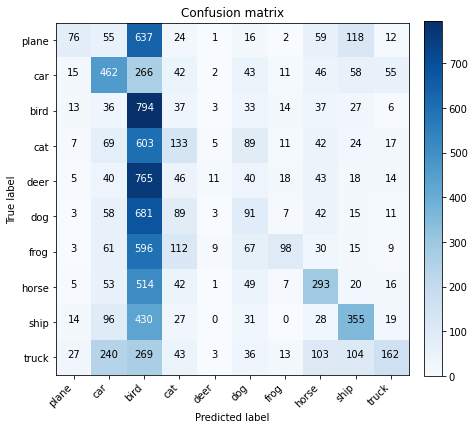

In [19]:
plot_confusion_matrix(confMatrix,classes)

- Existem muitas classificações a serem classificadas incorretamente na classe passáro.
- A acurácia do classificador quer no treino como no teste está muito baixa.

### Utilização do GridSearchCV para obter os melhores híper-parâmetros e os melhores resultados do score com as imagens a gray

De modo a descobrir os melhores parâmetros para o classificador recorreu-se ao uso do GridSearchCV.
GridSearchCV percorre um conjunto de hyper parâmetros e calcula o score, medida de precisão
dos métodos de predição, retornando o melhor conjunto de parâmetros consoante o score.


De forma a acelarar o tempo de processamento, incialmente estão a ser usadas as imagens a gray para testar os melhores hiper-parâmetros.
Estão a ser testados os seguintes parâmetros:
* Penalty - Termo de regularização
* Alpha - Constante que multiplica o termo de regularização
* Epsilon - Valor de epsilon

In [25]:
#parametros a serem testados
penalty = ['l2', 'l1']
alphaValue = [0.0001, 0.01]
epsilonValue = [0.01, 0.1, 0.5]
gread={'penalty':penalty,'alpha':alphaValue, 'epsilon': epsilonValue}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SGDClassifier(max_iter=5000, random_state=42),param_grid=gread,cv=2,verbose=2,n_jobs=-1)
gSearch.fit(Xtrain_gray,ytrain)

#Estimator que obteve melhor resultados
svm = gSearch.best_estimator_
#melhores parametros
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest_gray,ytest))
print('Parâmetros multi-classe:',par['penalty'],'alpha:',par['alpha'], 'epsilon:',par['epsilon'])

Fitting 2 folds for each of 12 candidates, totalling 24 fits
acertos no teste:  0.1827
Parâmetros multi-classe: l2 alpha: 0.0001 epsilon: 0.01


### Serão utilizados os parâmetros obtidos anteriormente para treinar o mesmo classificador com 20000 amostras de dados a cores

In [21]:
penalty = ['l2']
alphaValue = [0.0001]
epsilonValue = [0.01]
gread={'penalty':penalty,'alpha':alphaValue, 'epsilon': epsilonValue}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SGDClassifier(max_iter=5000, random_state=42),param_grid=gread,cv=2,verbose=2,n_jobs=-1)
gSearch.fit(Xtrain[0:20000],ytrain[0:20000])

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest))
print('Parâmetros multi-classe:',par['penalty'],'alpha:',par['alpha'], 'epsilon:',par['epsilon'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
acertos no teste:  0.2868
Parâmetros multi-classe: l2 alpha: 0.0001 epsilon: 0.01


- A partir dos resultados obtidos é possível observar que este classificador obtem melhores resultados com os dados a cores.
- Este classificador possui uma taxa muito baixa de acertos por isso serão testados outros classificadores multiclasse, de seguida vai ser testado o classificador Ridge.

<hr style="border:2px solid black"> </hr>

## Classificador Ridge (RidgeClassifier)

O Classificador Ridge convert os valores alvo para {-1,1} e depois trata o problema como uma tarefa
de regressão. Este classificador foi escolhido por ser simples e rápido de testar.

* Está a ser testado o melhor valor para o parâmetro alpha.
* Inicialmente está-se a testar o classificador com as imagens a cinzento.

In [20]:
alphaValue = [0.0001, 0.01, 0.1, 1, 2]
gread={'alpha':alphaValue}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(RidgeClassifier(random_state=42),param_grid=gread,cv=2,verbose=2,n_jobs=-1)
gSearch.fit(Xtrain_gray,ytrain)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest_gray,ytest))
print('Parâmetros multi-classe, alpha:',par['alpha'])

Fitting 2 folds for each of 5 candidates, totalling 10 fits
acertos no teste:  0.2765
Parâmetros multi-classe, alpha: 0.0001


* Melhor valor de alpha foi 0.001.
* Taxa de acerto no teste foi 0.2765.

### Utilização de 20000 amostras

De seguida foram utilizadas as imagens a cores, tendo sido usadas apenas 20000 amostras de treino, 
de forma a acelar o tempo de processamento.

In [22]:
alphaValue = [0.0001]
gread={'alpha':alphaValue}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(RidgeClassifier(random_state=42),param_grid=gread,cv=2,verbose=2,n_jobs=-1)
gSearch.fit(Xtrain[0:20000],ytrain[0:20000])

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest))
print('Parâmetros multi-classe, alpha:',par['alpha'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
acertos no teste:  0.308
Parâmetros multi-classe, alpha: 0.0001


### Teste com todos os dados

In [14]:
alphaValue = [0.0001]
gread={'alpha':alphaValue}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(RidgeClassifier(random_state=42),param_grid=gread,cv=2,verbose=2,n_jobs=-1)
gSearch.fit(Xtrain, ytrain)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest))
print('Parâmetros multi-classe, alpha:',par['alpha'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
acertos no teste:  0.3637
Parâmetros multi-classe, alpha: 0.0001


- Da mesma maneira que o outro classificador este possuí melhores resultados para imagens a cores.
- Este classificador teve uma taxa de acerto no conjunto de teste de 0.36.
- Este classificador possui melhor resultados que o classificador de descida de gradiente, mas será utilizado o classificador SVC para realizar um último teste.

<hr style="border:2px solid black"> </hr>

## Classificador SVC (SVC)

O classificador SVC funciona retornando um hiperplano que divide e categoriza os dados, é um algoritmo do tipo Support Vector Machine.

* Está a ser testado o melhor valor para o parâmetro C.
* Inicialmente está-se a testar o classificador com as imagens a cinzento.
* O classificador SVC funciona ambos para tarefas de classificação binária e multiclasse, para tarefas multiclasse utiliza-se um esquema 'one-vs-one'.

In [16]:
C = [0.01, 0.1, 1, 1.1]
gread={'C': C}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SVC(random_state=42, decision_function_shape='ovo'),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(Xtrain_gray,ytrain)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest_gray,ytest))
print('Parâmetros multi-classe, C:',par['C'])

Fitting 2 folds for each of 4 candidates, totalling 8 fits
acertos no teste:  0.4624
Parâmetros multi-classe, C: 1.1


### Teste com cores com somente 20000 amostras

In [15]:
C = [0.01, 0.1, 1, 1.1]
gread={'C': C}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SVC(random_state=42, decision_function_shape='ovo'),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(Xtrain[0:20000],ytrain[0:20000])

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest))
print('Parâmetros multi-classe, C:',par['C'])

Fitting 2 folds for each of 4 candidates, totalling 8 fits
acertos no teste:  0.5088
Parâmetros multi-classe, C: 1.1


- Foram somente utilzadas 20000 amostras e não todas as amostras pois treinar o modelo é um processo muito demoroso.

### Teste com todos os dados

In [27]:
C = [1.1]
gread={'C': C}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SVC(random_state=42, decision_function_shape='ovo'),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(Xtrain,ytrain)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest))
print('Parâmetros multi-classe, C:',par['C'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
acertos no teste:  0.5473
Parâmetros multi-classe, C: 1.1


- Este classificador teve uma taxa de acertos no conjunto de teste de 0.54.
- Este classificador de todos os testados é o que produz melhores resultados, sendo os melhores resultados com imagens a cores.
- Este classificador teve como desvantagem ter um tempo de processamento significativamente mais longo que os restantes.

<hr style="border:2px solid black"> </hr>

# Classificação binária

Na tarefa de classificação binária defeniu-se os exemplos classe "ship" como exemplos positivos e as imagens das restantes classes como exemplos negativos. Nesta tarefa foram também testados diferentes classificadores de forma a averiguar qual é mais benéfico para esta tarefa.

## Classificador SVC (SVC)

De forma semelhante à tarefa de classificação multiclasse utilizou-se também agora o classificador SVC. Entretanto utiliza-se agora um esquema do género "one-vs-rest".
* Foi testado o melhor valor para o parâmetro C.


In [14]:
C = [0.01, 0.1, 1, 1.1, 1.4, 1.5]
gread={'C': C}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SVC(random_state=42, decision_function_shape='ovr'),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(Xtrain[0:20000],ytrain_b[0:20000])

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest_b))
print('Parâmetros multi-classe, C:',par['C'])

Fitting 2 folds for each of 6 candidates, totalling 12 fits


C:\Users\migue\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


acertos no teste:  0.935
Parâmetros multi-classe, C: 1.5


### Utilização de 30000 amostras dos dados de treino

In [31]:
C = [1.4, 1.5, 1.8, 2]
gread={'C': C}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SVC(random_state=42, decision_function_shape='ovr'),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(Xtrain[0:30000],ytrain_b[0:30000])

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest_b))
print('Parâmetros multi-classe, C:',par['C'])

Fitting 2 folds for each of 4 candidates, totalling 8 fits


C:\Users\migue\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


acertos no teste:  0.9409
Parâmetros multi-classe, C: 2


### Utilização de 40000 dos dados de treino

In [14]:
C = [2, 2.2, 1.5]
gread={'C': C}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SVC(random_state=42, decision_function_shape='ovr'),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(Xtrain[0:40000],ytrain_b[0:40000])

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest_b))
print('Parâmetros multi-classe, C:',par['C'])

Fitting 2 folds for each of 3 candidates, totalling 6 fits


C:\Users\migue\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


acertos no teste:  0.9424
Parâmetros multi-classe, C: 2.2


In [17]:
C = [2.2, 2.5]
gread={'C': C}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SVC(random_state=42, decision_function_shape='ovr'),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(Xtrain,ytrain_b)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest_b))
print('Parâmetros multi-classe, C:',par['C'])

Fitting 2 folds for each of 2 candidates, totalling 4 fits


C:\Users\migue\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


acertos no teste:  0.9435
Parâmetros multi-classe, C: 2.5


* Classificador obteve uma taxa de acertos no teste de 0.94
* o melhor valor para o argumento C foi 2.5

<hr style="border:2px solid black"> </hr>

## Classificador Processo Gaussiano (GaussianProcessClassifier)

O Classificador de processo gaussiano utilizado baseia-se na implementação de um algoritmo de distribuição de probalilidade Gaussiana com aproximação de Laplace.

* O parâmetro a ser testado é o parâmetro multiClass que permite defenir se o classificador segue um esqueca "one vs rest" ou "one vs one".

In [16]:
multiClass = ['one_vs_rest', 'one_vs_one']
gread={'multi_class': multiClass}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(GaussianProcessClassifier(random_state=42),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(Xtrain[0:20000],ytrain_b[0:20000])

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest_b))
print('Parâmetros multi-classe, multi_class:',par['multi_class'])

Fitting 2 folds for each of 2 candidates, totalling 4 fits


C:\Users\migue\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


acertos no teste:  0.9
Parâmetros multi-classe, multi_class: one_vs_rest


- O classificador obteve uma taxa de acerto no conjunto de teste de 0.9 porcento.
- O classificador de processo gaussinao possui uma performance relativamente inferior ao SVC e por isso prevalece a utilização do SVC para obter os melhores resultados.
- Por fim vai ser testado mais um classificador binário o RandomForestClassifier.

<hr style="border:2px solid black"> </hr>

## Classificador de Floresta Aleatória (RandomForestClassifier)

Classificador de Floresta Aleatória é um classificador que contém um número de árvores de decisão em vários sub-conjuntos do conjunto de dados. Este classificador costuma ter bons resultados e é relativamente rápido.

* Foi testado o melhor valor para o parâmetro n_estimators que controla o número de árvores na floresta.

In [19]:
n_estimators = [10, 100, 150]
gread={'n_estimators': n_estimators}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(RandomForestClassifier(random_state=42),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(Xtrain[0:20000],ytrain_b[0:20000])

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest_b))
print('Parâmetros multi-classe, n_estimators:',par['n_estimators'])

Fitting 2 folds for each of 3 candidates, totalling 6 fits


C:\Users\migue\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


acertos no teste:  0.9212
Parâmetros multi-classe, n_estimators: 100


In [28]:
n_estimators = [100]
gread={'n_estimators': n_estimators}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(RandomForestClassifier(random_state=42),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(Xtrain, ytrain_b)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(Xtest,ytest_b))
print('Parâmetros multi-classe, n_estimators:',par['n_estimators'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\Users\migue\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


acertos no teste:  0.9233
Parâmetros multi-classe, n_estimators: 100


* Este classificador teve uma taxa de acertos no teste de 0.92.
* Este classificador possui uma taxa de acerto inferior ao SVC, porém tem a vantagem de o tempo de processamento é significativamente mais curto.

<hr style="border:2px solid black"> </hr>

# Normalização da média para um e variância unitária

A técnica de normalização dos dados irá ser agora aplicada aos dados, realizando um rescale da média dos dados para 0 e do desvio padrão para 1.

Média e desvio padrão dos dados no eixo X antes de ser aplicado o StandardScaler.

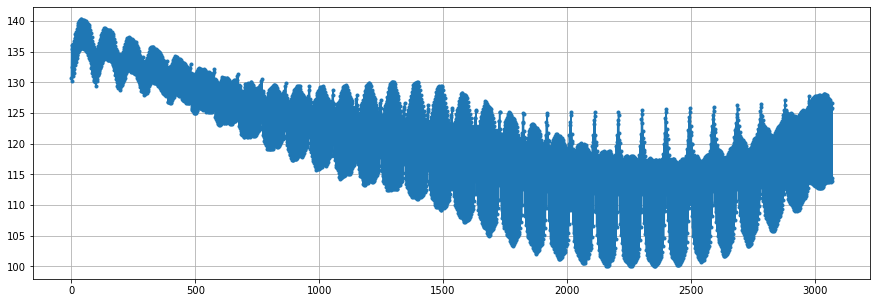

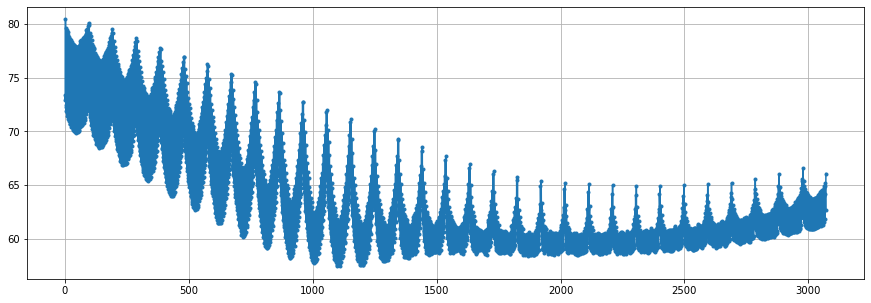

In [14]:
#média dos dados no eixo X
m=np.mean(Xtrain, axis=0)
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(m,'.-')

#desvio padrão dos dados no eixo X
s=np.std(Xtrain,axis=0)
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(s,'.-')


A partir dos seguintes gráficos pode-se observar a média e o desvio padrão dos dados por cada componente
antes de ser aplicado o StandardScaler, com os dados ainda não normalizados.

### Aplicar Standard Scaler (normalização dos dados)

In [15]:
#Standard Scaler
sc = StandardScaler().fit(Xtrain)
XtrainScale = sc.transform(Xtrain)
XtestScale = sc.transform(Xtest)

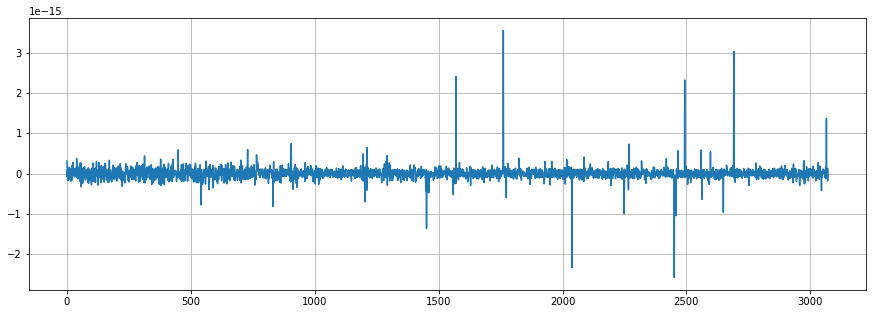

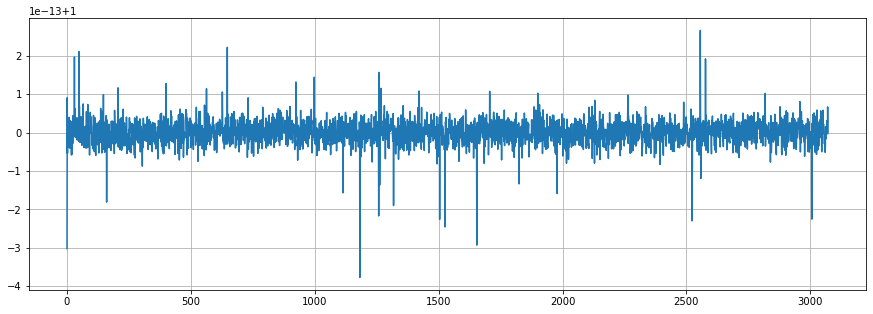

In [16]:
#desvio padrão dos dados no eixo X
s=np.std(XtrainScale,axis=0)
plt.figure(figsize=(15,5))
#média dos dados no eixo X
m=np.mean(XtrainScale,axis=0)
plt.grid()
plt.plot(m)
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(s)

Os dados agora apresentam uma média de 0  e uma variância unitária.

<hr style="border:2px solid black"> </hr>


# Verificar se a normalização dos dados é benéfico para as tarefas de classificação

## Multi-classe

A tarefa de classificação multiclasse vai ser agora executada com os dados normalizados, para isto vai ser utilizado inicialmente o classificador SVC que foi o que obteve previamente os melhores resultados.

In [15]:
C = [1.1]
gread={'C': C}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SVC(random_state=42, decision_function_shape='ovo'),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(XtrainScale, ytrain)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(XtestScale, ytest))
print('Parâmetros multi-classe, C:',par['C'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
acertos no teste:  0.5522
Parâmetros multi-classe, C: 1.1


Os testes foram realizados nas mesmas condições e o resutados foram:
- No caso do classificador com somente 20000 amostras, possui uma melhor performance ( score: 0.5088).
- No caso da utilização dos dados todos também possui uma melhor performance (socre: 0.5473).

Vai ser agora testado o classificador multiclasse Ridge com os dados normalizados.

In [17]:
alphaValue = [0.0001]
gread={'alpha':alphaValue}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(RidgeClassifier(random_state=42),param_grid=gread,cv=2,verbose=2,n_jobs=-1)
gSearch.fit(XtrainScale, ytrain)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(XtestScale,ytest))
print('Parâmetros multi-classe, alpha:',par['alpha'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
acertos no teste:  0.3637
Parâmetros multi-classe, alpha: 0.0001


Os testes foram realizados nas mesmas condições:
- O resultado foi precisamente o mesmo resultado com os dados não normalizados(score: 0.3637)

A partir dos resultados obtidos notou-se que os resultados obtidos no conjunto de teste com a normalização dos dados foram bastante semelhantes aos obtidos sem a normalização, tendo a normalização sido ligeiramente favorável no caso do classificador SVC. 

## Binário

Foi realizada agora a tarefa de classificação binária com os dados normalizados.

In [18]:
C = [2.2, 2.5]
gread={'C': C}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(SVC(random_state=42, decision_function_shape='ovr'),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(XtrainScale,ytrain_b)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(XtestScale,ytest_b))
print('Parâmetros multi-classe, C:',par['C'])

Fitting 2 folds for each of 2 candidates, totalling 4 fits


C:\Users\migue\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


acertos no teste:  0.9438
Parâmetros multi-classe, C: 2.5


Os testes foram realizados nas mesmas condições
- A classificação possui ligeiramente resultados melhores com a diferença de 0.003 de acertos a mais (score: 0.9435)

In [18]:
n_estimators = [100]
gread={'n_estimators': n_estimators}


# cross-validation of 1, verbose para mostrar mensagens do tempo
gSearch = GridSearchCV(RandomForestClassifier(random_state=42),param_grid=gread,cv=2,verbose=2,n_jobs=3)
gSearch.fit(XtrainScale, ytrain_b)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no teste: ',svm.score(XtestScale,ytest_b))
print('Parâmetros multi-classe, n_estimators:',par['n_estimators'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\Users\migue\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


acertos no teste:  0.9233
Parâmetros multi-classe, n_estimators: 100


Os testes foram realizados nas mesmas condições:
- O resultado foi precisamente o mesmo resultado com os dados não normalizados(score: 0.9233)

Semelhantemente ao que aconteceu na classificação multiclasse, os resultados obtidos com ou sem normalização dos dados foram semelhantes.

<hr style="border:2px solid black"> </hr>

## Análise de componentes principais

Realizou-se transformação dos dados em componentes principais para reduzir a dimensionalidade dos dados, e
verificar se esta transformção é benéfica para a tarefa de classificação.

###  Transformação PCA com o classificador SVC multiclasse

De forma a testar o desempenho da transformação PCA em classificação multiclasse, utilizou-se o classificador SVC
com os parâmetros que previamente obtiveram um melhor desempenho.

Através da utilização de GridSearchCV está-se a averiguar agora:

* Número adequado de componentes principais.
* Decidir se a utilização de whiten é benéfico.

In [17]:
#PCA 
pca = PCA(n_components=0.9)
#SVC Classifier
svc = SVC()

#pipeline
pipe = Pipeline([  ('pca', pca), ('svc', svc)])

#parameters
param_grid = {
    'svc__C':[1.1],
    'svc__decision_function_shape': ['ovo'],
    'pca__whiten': [True,False],
    'pca__n_components': [0.8,0.9,0.95]
  
}

gSearch = GridSearchCV(pipe,param_grid,cv=2,verbose=1,n_jobs=3)
gSearch.fit(Xtrain,ytrain)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no treino: ',svm.score(Xtrain,ytrain))
print('acertos no teste: ',svm.score(Xtest,ytest))
print('Parâmetros:',par)


Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed: 32.7min finished


acertos no treino:  0.81914
acertos no teste:  0.5674
Parâmetros: {'pca__n_components': 0.9, 'pca__whiten': True, 'svc__C': 1.1, 'svc__decision_function_shape': 'ovo'}


A transformação dos dados com PCA teve melhores resultados na classificação multiclasse com SVC com os seguintes parâmetros:

* Realização de whiten, (whiten=True), logo a utilização de whiten é benéfico.
* número de componentes principais que mantêm 0.9 porcento da variânca total.

In [82]:
from sklearn.decomposition import PCA

pca=PCA(n_components=0.9,whiten=True).fit(Xtrain)
X1p=pca.transform(Xtrain)
X2p=pca.transform(Xtest)
print('Nº of Principal Components kept: %d'%X1p.shape[1])

Nº of Principal Components kept: 99


In [19]:
print("soma da percentagem da variância  por componente ",((pca.explained_variance_ratio_.sum())))

soma da percentagem da variância  por componente  0.9003187633153609


Foi realizada uma análise em componente principais com 99 componentes, uma redução da dimensionalidade dos dados para 3.17 porcento do tamanho original.

###  Transformação PCA com o classificador Ridge multiclasse

Testou-se também o desempenho da transformação PCA com o classificador Ridge Multiclasse.

In [73]:
pca = PCA()
ridge = RidgeClassifier(random_state=42,alpha=0.001)
#conaRidge = RidgeClassifier(random_state=42,alpha=0.001)

#pipeline
pipe = Pipeline([  ('pca', pca), ('ridge', ridge)])

#parameters
param_grid = {
    
    'pca__whiten': [True],
    'pca__n_components': [0.7,0.9,0.95]
  
}

gSearch = GridSearchCV(pipe,param_grid,cv=2,verbose=1,n_jobs=3)
gSearch.fit(Xtrain,ytrain)

svm = gSearch.best_estimator_
par = gSearch.best_params_

print('acertos no treino: ',svm.score(Xtrain,ytrain))
print('acertos no teste: ',svm.score(Xtest,ytest))
print('Parâmetros:',par)


Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:  9.1min finished


acertos no treino:  0.396
acertos no teste:  0.3955
Parâmetros: {'pca__n_components': 0.9, 'pca__whiten': True}


O classificador Ridge obteve também um melhor desempenho com a transformação PCA

### PCA com data normalizada (StandarScaler)

Decidiu-se verificar se o pre-processamento de dados com PCA obtém melhores resultados com data normalizada (StandardScaler). De forma a conseguir averiguar se isto é benéfico foram realizados testes utilizando a  transformação PCA em classificação multiclasse com o classificador SVC.

In [81]:
from sklearn.decomposition import PCA
#PCA
pca=PCA(n_components=0.9,whiten=True).fit(Xtrain)
#transformação
X_train_p_scale=pca.transform(XtrainScale)
X_test_p_scale =pca.transform(XtestScale)


In [22]:
svc_scaled = SVC(random_state=42, decision_function_shape='ovo',C=1.1)
svc_scaled.fit(X_train_p_scale,ytrain)

SVC(C=1.1, decision_function_shape='ovo', random_state=42)

Confusion matrix, without normalization


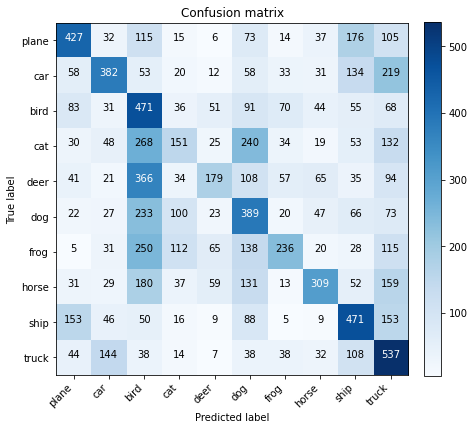

In [23]:
ytest_e=svc_scaled.predict(X_test_p_scale)
conf_matrix = confusion_matrix(ytest,ytest_e)
plot_confusion_matrix(conf_matrix,classes)

In [24]:
print('Total number of erros %d (in %d)'%(np.sum(ytest_e!=ytest),ytest.shape[0]), )
print('Score',str(1-( np.sum(ytest_e!=ytest) /ytest.shape[0])))

Total number of erros 6448 (in 10000)
Score 0.35519999999999996


O classificador SVC multiclasse com PCA obteve resultados significivamente piores com os dados normalizados. Não é benéfica a normalização dos dados antes de ser realizada a transformação PCA com o classificador SVC multiclasse.

## Desempenho dos melhores classificadores

O desempenho dos melhores classificadores ambos para a tarefa de classificação multiclasse e binária vai ser agora averiguado através de diferentes métricas de desempenho.


### Melhor Classificador Multiclasse (Classificador SVC)

A partir dos testes realizados, utilizando o GridSearch, o classificador SVC foi o que teve melhores resultados
para o processo de classificação multiclasse.

In [83]:
svc = SVC(random_state=42, decision_function_shape='ovo',C=1.1)
svc.fit(X1p,ytrain)

SVC(C=1.1, decision_function_shape='ovo', random_state=42)

Confusion matrix, without normalization


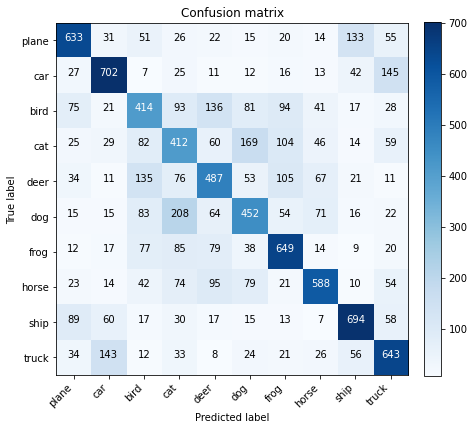

In [84]:
ytest_e=svc.predict(X2p)
conf_matrix = confusion_matrix(ytest,ytest_e)
plot_confusion_matrix(conf_matrix,classes)

####  Score com os dados de treino:

In [85]:
ytrain_e=svc.predict(X1p)

In [86]:
print('Score no conjunto de treino:',str(1-( np.sum(ytrain_e!=ytrain) /ytrain.shape[0])))

Score no conjunto de treino: 0.81914


In [91]:
 print(skm.classification_report(ytrain,ytrain_e))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      5000
           1       0.92      0.91      0.92      5000
           2       0.70      0.70      0.70      5000
           3       0.77      0.78      0.78      5000
           4       0.71      0.75      0.73      5000
           5       0.86      0.76      0.81      5000
           6       0.77      0.83      0.80      5000
           7       0.91      0.83      0.87      5000
           8       0.85      0.89      0.87      5000
           9       0.90      0.89      0.90      5000

    accuracy                           0.82     50000
   macro avg       0.82      0.82      0.82     50000
weighted avg       0.82      0.82      0.82     50000



A precisão no conjunto de treino foi 0.819 sendo um valor bom. Se a predição com os valores de treino dessem valores muito elevados poderia ser sinal que o modelo poderia estar em sobre-aprendizagem.

####  Score com os dados de teste:

In [87]:
print('Total number of erros %d (in %d)'%(np.sum(ytest!=ytest_e),X2p.shape[0]))
print('Score',str(1-( np.sum(ytest_e!=ytest) /ytest.shape[0])))

Total number of erros 4326 (in 10000)
Score 0.5674


Análise do desempenho do modelo vai ser medida através das seguintes métricas de desempenho:
* precision
* recall
* accuracy
* f-score

In [88]:
print(skm.classification_report(ytest,ytest_e))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1000
           1       0.67      0.70      0.69      1000
           2       0.45      0.41      0.43      1000
           3       0.39      0.41      0.40      1000
           4       0.50      0.49      0.49      1000
           5       0.48      0.45      0.47      1000
           6       0.59      0.65      0.62      1000
           7       0.66      0.59      0.62      1000
           8       0.69      0.69      0.69      1000
           9       0.59      0.64      0.61      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000



O classificador obteve bons resultados, tendo bons valores de score ambos com os dados de treino
e com os dados de teste. Teve bom desempenho para os valores de precision, recall, f1-score, support, o classificador SVC de todos os classificadores multiclasse testados foi o que cumpriu melhor a tarefa de classificação multiclasse.

### Melhor Classificador Binario (Classificador SVC)

A partir dos testes realizados, utilizando o GridSearch, o classificador SVC foi o que teve melhores resultados
para o processo de classificação multiclasse.

In [17]:
svcBin = SVC(random_state=42, decision_function_shape='ovr',C=2.5)
svcBin.fit(XtrainScale,ytrain_b)

C:\Users\duart\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(C=2.5, random_state=42)

Confusion matrix, without normalization


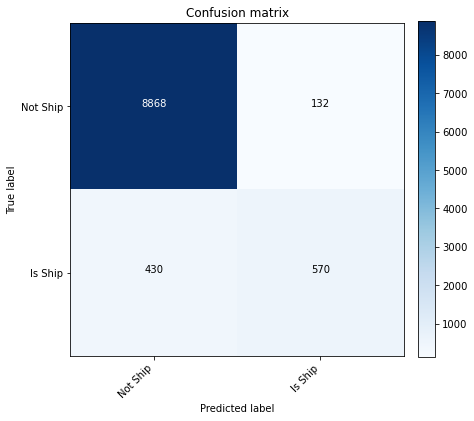

In [18]:
ytest_bin_e=svcBin.predict(XtestScale)
conf_matrix = confusion_matrix(ytest_b,ytest_bin_e)
plot_confusion_matrix(conf_matrix,classesBin)

####  Score com os dados de teste:

Como se pode observar pela matriz de confusão, ainda há um número de falsos negativos que poderia ser reduzido, isto irá ser realizado a seguir a partir de um processo de calibração do modelo.

Análise do desempenho do modelo foi realizada através das seguintes métricas:
* precision
* recall
* accuracy
* f-score

In [44]:
 print(skm.classification_report(ytest_b,ytest_bin_e))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9000
           1       0.81      0.57      0.67      1000

    accuracy                           0.94     10000
   macro avg       0.88      0.78      0.82     10000
weighted avg       0.94      0.94      0.94     10000



Como se pode observar para as diferentes métricas de desempenho o modelo obteve bons resultados. Apresentando um score de 0.94.

####  Score com os dados de treino:

Confusion matrix, without normalization


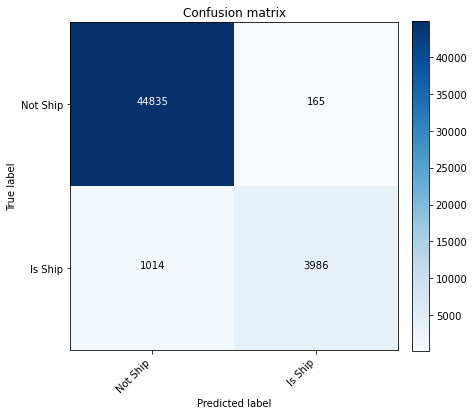

In [89]:
ytrain_bin_e=svcBin.predict(XtrainScale)
conf_matrix_train_bin = confusion_matrix(ytrain_b,ytrain_bin_e)
plot_confusion_matrix(conf_matrix_train_bin,classesBin)

In [90]:
 print(skm.classification_report(ytrain_b,ytrain_bin_e))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     45000
           1       0.96      0.80      0.87      5000

    accuracy                           0.98     50000
   macro avg       0.97      0.90      0.93     50000
weighted avg       0.98      0.98      0.98     50000



O score no conjunto de treino foi de 0.98

## Calibração do modelo

Nesta etapa é realizada a calibração do modelo do classificador binário SVC. Pretende-se 
diminuir o número de falsos negativos, mantendo um nivél semelhante do score. Para isto é necessário alterar o threshold de decisão, inicialmente é necessário obter a função de decisão a 
partir do método decision_function.

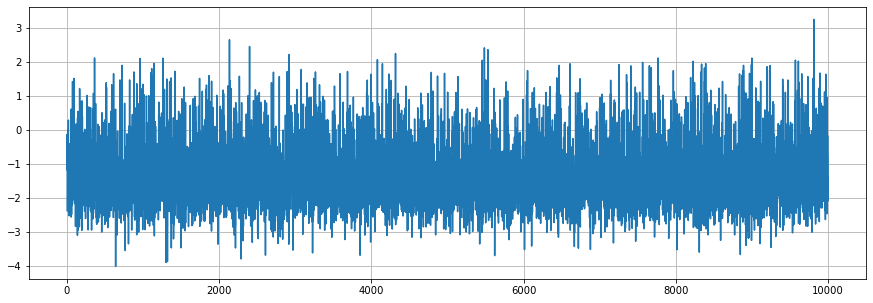

In [21]:
#obter a função de decisão do modelo
r2e=svcBin.decision_function(XtestScale)
plt.figure(figsize=(15,5))
plt.plot(r2e)
plt.grid(True)

Vai ser vizualisada a Curva ROC e o precision/recall.

In [22]:
#Obter ROC Curves e o ponto operacional corrente do modelo
fpr,tp,t=skm.roc_curve(ytest_b,r2e)
area1=skm.roc_auc_score(ytest_b,r2e)
prec,rec,thresh=skm.precision_recall_curve(ytest_b,r2e)
area2=skm.average_precision_score(ytest_b,r2e)


In [23]:
#Obter o ponto operacional
r1= (conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0]))
f1= (conf_matrix[0][1]/(conf_matrix[0][1]+conf_matrix[0][0]))

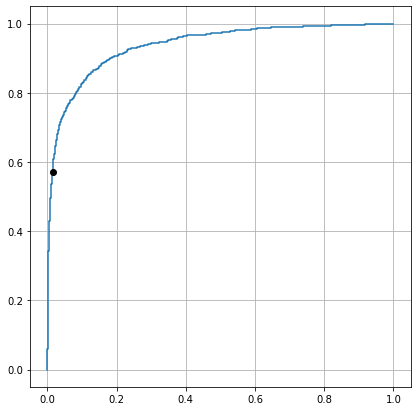

In [24]:
#METER LOGO AQUI O PONTO OPERACIONAL
plt.figure(figsize=(7,7))
plt.plot(fpr,tp)
plt.plot(f1,r1,'ok')
plt.axis('scaled')
plt.grid(True)

### Alterar o threshold - Reduzir o número de falsos negativos

Pretende-se agora reduzir o número de falsos negativos, visto que estes prejudicam os resultados
obtidos.
<p>
Pretende-se agora descobrir o threshold em que os elementos verdadeiros positivos têm uma taxa superior a 0.9 


In [65]:
#Calibrar
np.argwhere(tp>=0.88)[0:10]

array([[636],
       [637],
       [638],
       [639],
       [640],
       [641],
       [642],
       [643],
       [644],
       [645]], dtype=int64)

In [66]:
t[636]

-0.9756360980212431

Alterar o threshold da função de decisão.

In [67]:
CM2=confusion_matrix(ytest_b,(r2e>-0.9756360980212431)*1)

Pretende-se agora comparar a matriz de confusão original com a matriz de confusão calibrada.

In [68]:
print("Matriz de confusão original:")
print(conf_matrix)
print("\n")
print("Matriz de confusão calibrada:")
print(CM2)

Matriz de confusão original:
[[8868  132]
 [ 430  570]]


Matriz de confusão calibrada:
[[7612 1388]
 [ 120  880]]


O número de falsos negativos foi reduzido de 430 para 120

In [69]:
r1= (conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0]))
f1= (conf_matrix[0][1]/(conf_matrix[0][1]+conf_matrix[0][0]))

In [70]:
r2= (CM2[1][1]/(CM2[1][1]+CM2[1][0]))
f2= (CM2[0][1]/(CM2[0][1]+CM2[0][0]))

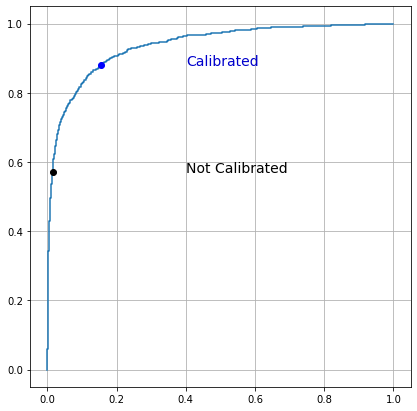

In [71]:
plt.figure(figsize=(7,7))

plt.plot(fpr,tp)
plt.axis('scaled')

plt.plot(f1,r1,'ok')
plt.text(.4,.88,'Calibrated',fontsize=14,color=[0,0,0.8])

plt.plot(f2,r2,'ob')
plt.text(.4,.57,'Not Calibrated',fontsize=14,color=[0,0,0])

plt.grid(True)

### Comparação de modelos

Vai ser comparado agora o classificador binário SVC com o classificador binário RandomForest
com os melhores parâmetros definidos anteriormente.

In [72]:
#Treinar classificador RandomForest
rand = RandomForestClassifier(random_state=42,n_estimators=100)
rand.fit(XtrainScale,ytrain_b)


<ipython-input-72-a341edaf8d82>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rand.fit(XtrainScale,ytrain_b)


RandomForestClassifier(random_state=42)

Confusion matrix, without normalization


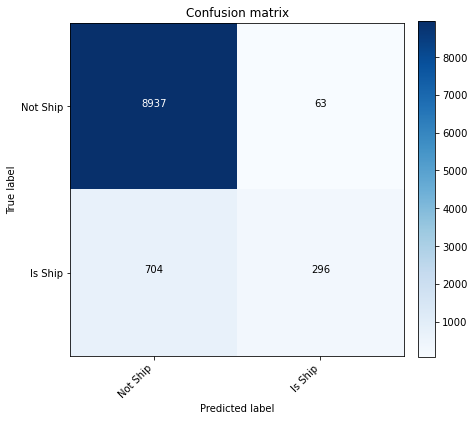

In [73]:
#obter matriz de confusão
ytest_bin_e_rand=rand.predict(XtestScale)
conf_matrix_rand = confusion_matrix(ytest_b,ytest_bin_e_rand)
plot_confusion_matrix(conf_matrix_rand,classesBin)

In [74]:
#obter funcao de decisao
r2f=rand.predict_proba(XtestScale)[:,1]

Curva ROC de ambos os modelos

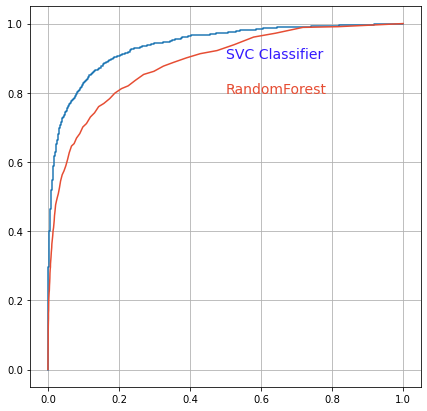

In [75]:
#Mostrar CurvaRoc
fpr_rand,tp_rand,t_rand=skm.roc_curve(ytest_b,r2f)

r3= (conf_matrix_rand[1][1]/(conf_matrix_rand[1][1]+conf_matrix_rand[1][0]))
f3= (conf_matrix_rand[0][1]/(conf_matrix_rand[0][1]+conf_matrix_rand[0][0]))

plt.figure(figsize=(7,7))

plt.plot(fpr,tp)
plt.text(.5,.9,'SVC Classifier',fontsize=14,color=[0.2,0.1,1])
plt.plot(fpr_rand,tp_rand,color=[0.9,0.3,0.2])
plt.text(.5,.8,'RandomForest',fontsize=14,color=[0.9,0.3,0.2])

plt.grid(True)

Calibração do modelo Random Forest.

In [92]:
#Calibrar randomForest
np.argwhere(tp_rand>=0.80)[0:10]

array([[82],
       [83],
       [84],
       [85],
       [86],
       [87],
       [88],
       [89],
       [90],
       [91]], dtype=int64)

In [93]:
t_rand[82]

0.15

In [96]:
CM3=confusion_matrix(ytest_b,(r2f>0.15)*1)
print("Matriz de confusão RandomForest original:")
print(conf_matrix_rand)
print("\n")
print("Matriz de confusão RandomForest calibrada:")
print(CM3)

Matriz de confusão RandomForest original:
[[8937   63]
 [ 704  296]]


Matriz de confusão RandomForest calibrada:
[[7304 1696]
 [ 201  799]]


Como se pode observar o número de falsos negativos dexeu de 704 para 231

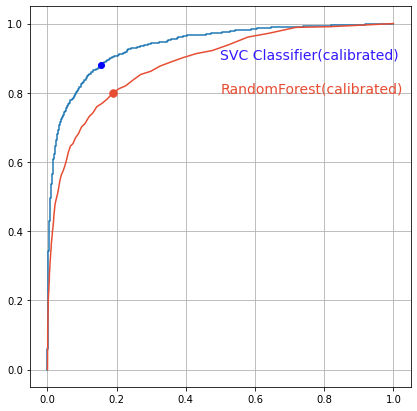

In [97]:
r3= (CM3[1][1]/(CM3[1][1]+CM3[1][0]))
f3= (CM3[0][1]/(CM3[0][1]+CM3[0][0]))

plt.figure(figsize=(7,7))

plt.plot(fpr,tp)
plt.text(.5,.9,'SVC Classifier(calibrated)',fontsize=14,color=[0.2,0.1,1])


plt.plot(fpr_rand,tp_rand,color=[0.9,0.3,0.2])
plt.text(.5,.8,'RandomForest(calibrated)',fontsize=14,color=[0.9,0.3,0.2])

plt.plot(f2,r2,'ob')
plt.plot(f3,r3,'.',ms=15,color=[0.9,0.3,0.2])
plt.axis('scaled')
plt.grid(True)

Para a tarefa de classificação binária o classificador SVC foi o que teve melhor desempenho.
Teve um melhor score e menor número de falsos negativos.